Kalman Filter (KF)
-----
<br>
<center><img src="https://raw.githubusercontent.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/master/animations/05_dog_track.gif" height="500"/></center>

By The End Of This Session You Should Be Able To:
----

- Define a Kalman Filter (KF)
- Identify when to use a KF
- Write the parts of a KF

KF History
-----

<center><img src="https://upload.wikimedia.org/wikipedia/commons/a/ac/Rudolf_Kalman.jpg" height="500"/></center>

Rudolf (Rudi) Emil Kálmán developed it in the 1960s.

He incorporated into the Apollo Lunar Mission navigation.

Apollo code 
-----

```
6037        FLAGORGY        TC       INTPRET             #  DIONYSIAN FLAG WAVING

034090,000243: 32,3241    13247        BZF      P63SPOT4 #  BRANCH IF ANTENNA ALREADY IN POSITION 1
034091,000244: 
034092,000245: 32,3242    33254        CAF      CODE500  #  ASTRONAUT:     PLEASE CRANK THE
034093,000246: 32,3243    04616        TC       BANKCALL #                 SILLY THING AROUND
034094,000247: 32,3244    20623        CADR     GOPERF1                               
034095,000248: 32,3245    16001        TCF      GOTOP00H #  TERMINATE
034096,000249: 32,3246    13235        TCF      P63SPOT3 #  PROCEED        SEE IF HE'S LYING

034101,000254: 32,3251    04635        TC       POSTJUMP #  OFF TO SEE THE WIZARD ...
034102,000255: 32,3252    74126        CADR     BURNBABY
```

Apollo code 
-----

[https://github.com/chrislgarry/Apollo-11](https://github.com/chrislgarry/Apollo-11)

or [here](http://www.ibiblio.org/apollo/listings/Comanche055/KALCMANU_STEERING.agc.html)

Intuitively, what does Kalman Filter (KF) do?
----
<br>
<center><img src="https://www.codeproject.com/KB/recipes/865935/cycle.png" width="500"/></center>

KF models state.

Combines multiple sources of information to give an better estimate than the sources independently.



Often one of the sources is the past, thus can modeling state transitions.

KF works if both sources are __uncertain__.

Uncertainties can be due to many things such as:

1. Initial Conditions
2. Unmodeled Effects 
3. Dynamic Changes

KF FTW
----

Can model __continuous__ distributions.

KF only store current state (no history).

KF updates easily and fast, therefore can be used in real-time systems.

[Source](https://github.com/mikemull/Notebooks/blob/master/Kalman-Slides-PyDataChicago2016.ipynb)

What are applications for KF?
-------

- Motion Planning:
    - Navigation - Estimating the position and orientation
    - Mapping - Estimating the world around the robot
    - Localization - Estimating your position relative to a local world
    - SLAM - Mapping and Localizing simultaneously
    - Domains: Robots, Self Driving Cars, Touchpads
- Computer vision/image processing
- Algorithmic Trading 
- Weather prediction

Why are they called Kalman "Filters"?
------

From signal processing, observations are always: __Signal + Noise__

KF try to filter out noise to have a better model of signal.

KF combine:
------
<center><img src="https://www.researchgate.net/profile/Desineni_Naidu/publication/263351641/figure/fig3/AS:267612479291404@1440815195127/Figure-2-Linear-Continuous-Time-Kalman-Filter.png" height="500"/></center>
1. A model of a system
2. Data points from a specific instance of that system
3. Estimates of the internal state of the system in a particular state

KF updates
-----

For each new data point, there are two steps:

1. The KF will predict the system state so far
2. Take in the next actual (fuzzy/noisy) data sample and use it to update the state estimate

KF example
-----

<center><img src="images/oops.jpg" width="300"/></center>

I made a robot that runs away from me. Let's model how far the robot will get over time

KF for Time Series
------


A simple time series can be defined as:

$$
\begin{align}
\alpha_{t+1} & = \alpha_{t} + \eta_t  & \eta_t \sim N(-5, \sigma^2_{\eta}) \\
\end{align}
$$

Just signal - The next time point is lower by E[-5].

In [15]:
reset -fs

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import statsmodels.api as sm
# import statsmodels.tsa.api as smt

%matplotlib inline

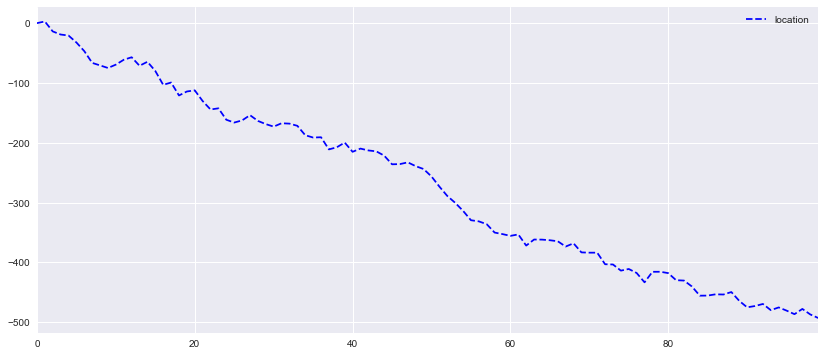

In [24]:
sigma_h = 10.0
n_states = 100
h = np.random.normal(-5, sigma_h, n_states)
h[0] = 0.0
a = np.cumsum(h)

df = pd.DataFrame(a[0:100], columns=['location'])
df.plot(figsize=(14,6), style='b--');

What we observe is a noise version:

$$
\begin{align}
y_t & = \alpha_t + \varepsilon_t \qquad & \varepsilon_t \sim
    N(0, \sigma_\varepsilon^2) \\
\end{align}
$$

observation = signal + noise

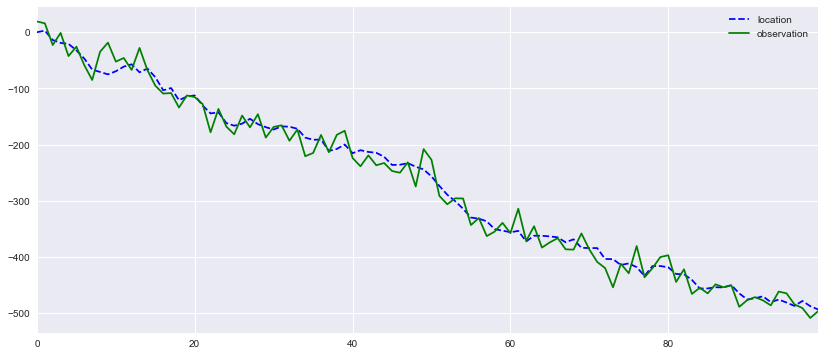

In [25]:
sigma_e = 15
e = np.random.normal(0, sigma_e, n_states)
df['observation'] = a[0:100] + e[0:100]
df.plot(figsize=(14,6), style=['b--', 'g-',]);

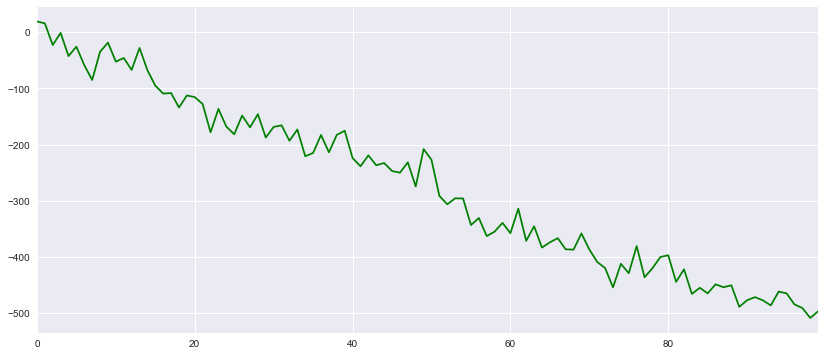

In [26]:
df.observation.plot(figsize=(14,6), style=['g-',]);

If we can only observe _y_, what can we say about &alpha;?


A Kalman __Filter__ tries to recover a signal by __filter__ing out the noise.

State Space Model for Our Example
-----

### State Equation

$$
\begin{align}
\alpha_{t+1} & = \alpha_{t} + \eta_t  & \eta_t \sim N(-5, \sigma^2_{\eta})
\\
\end{align}
$$

### Observation (or Measurement) Equation

$$
\begin{align}
y_t & = \alpha_t + \varepsilon_t \qquad & \varepsilon_t \sim
    N(0, \sigma_\varepsilon^2) \\
\end{align}
$$


The state equation describes the _dynamics_ of the system, how the system changes over time. The actual robot position at some time step.

The observation equation describes what is precieved. The __sensor__ reading of the robot at some time step.

Generalized Linear State Space Models
-----

### State Equation

$$
\begin{align}
\alpha_{t+1} & = T_t\alpha_{t} + R_t\eta_t  & \eta_t \sim N(-5, Q_t) \\
\end{align}
$$

### Observation Equation

$$
\begin{align}
y_t & = Z_t\alpha_t + \varepsilon_t \qquad & \varepsilon_t \sim
    N(0, H_t) \\
\end{align}
$$


- _T_ is transition matrix (from time to time+1)
- _Q_ is state covariance
- _Z_ is design matrix (the connection between state and observation)
- _H_ is observation covariance

<center><img src="images/overtime.png" height="500"/></center>

__Filtering__ is estimating the state for the latest observation. y<sub>t</sub>t, aka "Now"-casting

<center><img src="images/overtime.png" height="500"/></center>

__Prediction/forecasting__ is estimating the next state(s)

<center><img src="images/overtime.png" height="500"/></center>

__Smoothing/interpolation__ is estimating past states

<center><img src="https://raw.githubusercontent.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/master/animations/05_dog_track.gif" height="500"/></center>

Source:

- Mike Mull | Forecasting with the Kalman Filter
- https://www.youtube.com/watch?v=GmSXhmbv5Zg

KF steps
------

1) KF takes the existing knowledge of the state (e.g., velocity, mass, position)


2) Uses a dynamics model (e.g., astrophysics) to predict how the state will change


3) Calculates the uncertainty (covariance)


4) Compares the prediction to actual data (e.g., from sensors)

5) Updates the knowledge of the state guided by the optimum level of uncertainty

<br>
<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Basic_concept_of_Kalman_filtering.svg/800px-Basic_concept_of_Kalman_filtering.svg.png" width="700"/></center>

[Bivariate Normal Distribution Example](https://plot.ly/~erikjan/1/bivariate-normal-distribution/#plot)

[Bivariate Normal Distribution Demo](http://socr.ucla.edu/htmls/HTML5/BivariateNormal/)

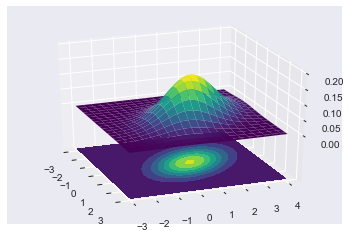

In [20]:
# HT: http://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 1.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

plt.show()

Check for understanding
-----

What is the shape of __Trivariate__ (3-D) Normal Distribution?

A cloud - a density cloud

KF in 2 dimensions
----

<center><img src="images/path.png" width="500"/></center>

KF formalism
-----

State definition: the smallest vector that summarizes the past of the system in full.

<center><img src="images/state.png" width="500"/></center>

<center><img src="images/measurement.png" width="500"/></center>

KF equations
------

<center><img src="images/state_est.png" width="500"/></center>

<center><img src="images/cov.png" width="500"/></center>

State Estimation
-----
<br>
<center><img src="images/state_est2.png" height="500"/></center>

<center><img src="images/cov_est2.png" width="500"/></center>

[Kalman Fitler simulator](https://www.cs.utexas.edu/~teammco/misc/kalman_filter/)

<center><img src="http://4.bp.blogspot.com/_nHcDA3NyAms/S9wgQYzoE6I/AAAAAAAAAQk/zR9YElumxlU/s1600/kalmaneq.png" height="500"/></center>

Check for understanding
------

One key component of Kalman filters, is that the product of two Gaussian is a another Gaussian. Why is this important?

<center><img src="https://www.codeproject.com/KB/recipes/865935/cycle.png" width="500"/></center>

An endless number of Gaussian pdfs can be multiplied over time,    
but the resulting function does not increase in complexity or number of terms

After each time epoch the new pdf is fully represented by a Gaussian function. 

KF recursive estimation
-------
<br>
<center><img src="http://3.bp.blogspot.com/-QSjqVDb9aqU/UPa6oBwkTOI/AAAAAAAAB90/aB72NnOrqTQ/s1600/binary_fractal_tree_02_15_45_05sqrt2.png" width="300"/></center>

You don't need to actually store every single fuzzy snapshot of the data; you can just keep a 'running state' in memory and then integrate each new snapshot into the newly updated state.

Thus supports real-time/ongoing (as opposed to batch-only) operations.

What is a major limitation of KF?
-----

The measurement noise in a Kalman filter is modeled as __additive white Gaussian noise__ (AWGN). Therefore the measurements are jointly Gaussian distributed.

The Kalman filter's estimation at each step is a linear combination of the measurements and since they are jointly Gaussian distributed, so is the result.

Your data might __not__ be modeled usefully with Gaussian!

Further Study
------

Around 20 different variations of the Kalman Filter have been developed with each having its own pros and cons:
EKF(extended kalman filter) or can do the trick:

- Extended Kalman Filter (For Non Linear Systems)
- Unscented Kalman Filter
- Kalman-Bucy Filter
- Error State Kalman Filter 

The idea can be extend with __Particle Filters__: Sequential Monte Carlo methods based on point mass representations of probability densities.

Summary
----

- Kalman filter (KF) can combinine information in the presence of uncertainty.
- Light on memory (KF's don’t need to keep any history other than the last state).
- Very fast, making them well suited for continuously changing systems and real time challenges.

<br>

Bonus Material
---

Kalman filters by another name
-------

Linear quadratic estimation

Further Study...
------

[Jupyter Notebook "book" on KF](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python)

The Kalman Filter is a method for solving the continuous version of Hidden Markov Models.

Check for understanding
------

What is the difference between HMM and KF?

Similar to a hidden Markov model but where the state space of the latent variables is continuous and where all latent and observed variables have a Gaussian distribution

An algorithm permitting exact inference in a linear dynamical system

The first good algorithm from SLAM
------

<center><img src="images/ef.png" height="500"/></center>

Extended Kalman filter (EKF)

<br>
<br>